### Projection Analysis: 

In [1]:
import os,random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os,argparse,pickle
import numpy as np
from sklearn.metrics import accuracy_score,  f1_score

In [2]:
sys.path.insert(0, '../')
from dataProcessing.dataModule import SingleDatasetModule
from trainers.trainerDisc import TLmodel
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
inPath = 'C:\\Users\\gcram\\Documents\\Smart Sense\\Datasets\\frankDataset\\'
params_path = 'C:\\Users\\gcram\\Documents\\GitHub\\TransferLearning-Sensors\\experiments\\params\\'
save_path = 'C:\\Users\\gcram\\Documents\\GitHub\\TransferLearning-Sensors\\saved\\'
	
datasetList = ['Dsads','Ucihar','Uschad','Pamap2']
n_classes = 4 
source = 'Ucihar'
target = 'Dsads'

###  Dsads to Ucihar: 

In [4]:
PATH_MODEL = f'../saved/best/FTmodel{source}_to_{target}_best.ckpt'
dm_source = SingleDatasetModule(data_dir=inPath,
                                datasetName=source,
                                n_classes=n_classes,
                                input_shape=(2,50,3),
                                batch_size=128)
dm_source.setup(split=False,normalize = True)
dm_target = SingleDatasetModule(data_dir=inPath,
                                datasetName=target,
                                input_shape=(2,50,3),
                                n_classes=n_classes,
                                batch_size=128)

dm_target.setup(split=False,normalize = True)


In [5]:
new_model = TLmodel.load_from_checkpoint(PATH_MODEL)
new_model.setDatasets(dm_source, dm_target)
predictions = new_model.predict()

c:\users\gcram\miniconda3\envs\torch_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
trueSource = predictions['trueSource']
predSource =  predictions['predSource']
latentSource =  predictions['latentSource']
trueTarget =  predictions['trueTarget']
predTarget =  predictions['predTarget']
latentTarget =  predictions['latentTarget']
probsTarget = predictions['probTarget']
classes = pd.unique(trueTarget)
N = len(classes)

In [32]:
accuracy_score(trueTarget,predTarget)
print(new_model.get_final_metrics())

{'acc_source_test': 0.9288089480048367, 'acc_target_all': 0.48270089285714285, 'cm_source': array([[1528,   79,   54,   61],
       [  14, 1417,  111,    2],
       [  84,   26, 1296,    0],
       [   3,   28,    9, 1904]], dtype=int64), 'cm_target': array([[ 630,   63,  741,    0],
       [ 667,  404,  347,   15],
       [ 767,   46,  595,   22],
       [   2, 1029,    9, 1831]], dtype=int64)}


In [33]:
source_embedded = TSNE(n_components=2).fit_transform(latentSource)
target_embedded = TSNE(n_components=2).fit_transform(latentTarget)


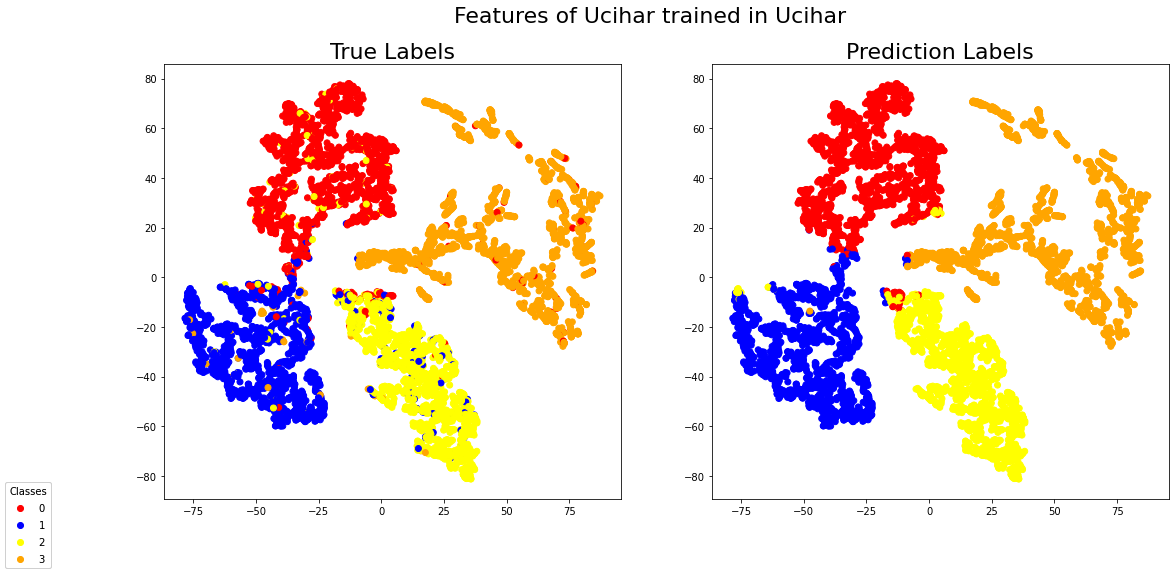

In [34]:
x = source_embedded[:,0]
y = source_embedded[:,1]
label = trueSource
colors = ['red','green','blue','purple','yellow','orange']
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (18,8))
fig.suptitle(f'Features of {source} trained in {source}',fontsize = 22)
scatter = ax[0].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title(f'True Labels',fontsize = 22)

label = predSource
colors = ['red','green','blue','purple','yellow','orange']
scatter = ax[1].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
#legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
#ax[1].add_artist(legend1)
ax[1].set_title(f'Prediction Labels',fontsize = 22)
plt.savefig(os.path.join(save_path,f'featuresSource_{source}.png'))


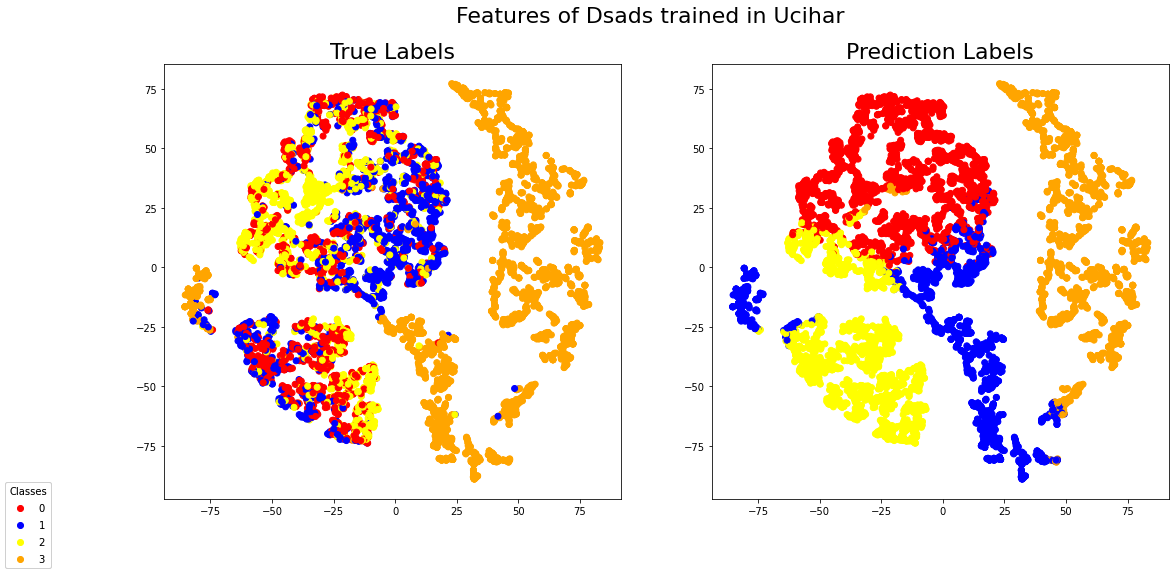

In [35]:
x = target_embedded[:,0]
y = target_embedded[:,1]
label = trueTarget
colors = ['red','green','blue','purple','yellow','orange']
fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize = (18,8))
fig.suptitle(f'Features of {target} trained in {source}',fontsize = 22)
scatter = ax[0].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title(f'True Labels',fontsize = 22)
label = predTarget
colors = ['red','green','blue','purple','yellow','orange']
scatter = ax[1].scatter(x, y, c=label,cmap=mpl.colors.ListedColormap(colors))
# legend1 = fig.legend(*scatter.legend_elements(), loc="lower left" ,   title="Classes")
# ax[1].add_artist(legend1)
ax[1].set_title(f'Prediction Labels',fontsize = 22)
plt.savefig(os.path.join(save_path,f'features_from{source}_to{target}.png'))



### Analysing Classsifier confidence:

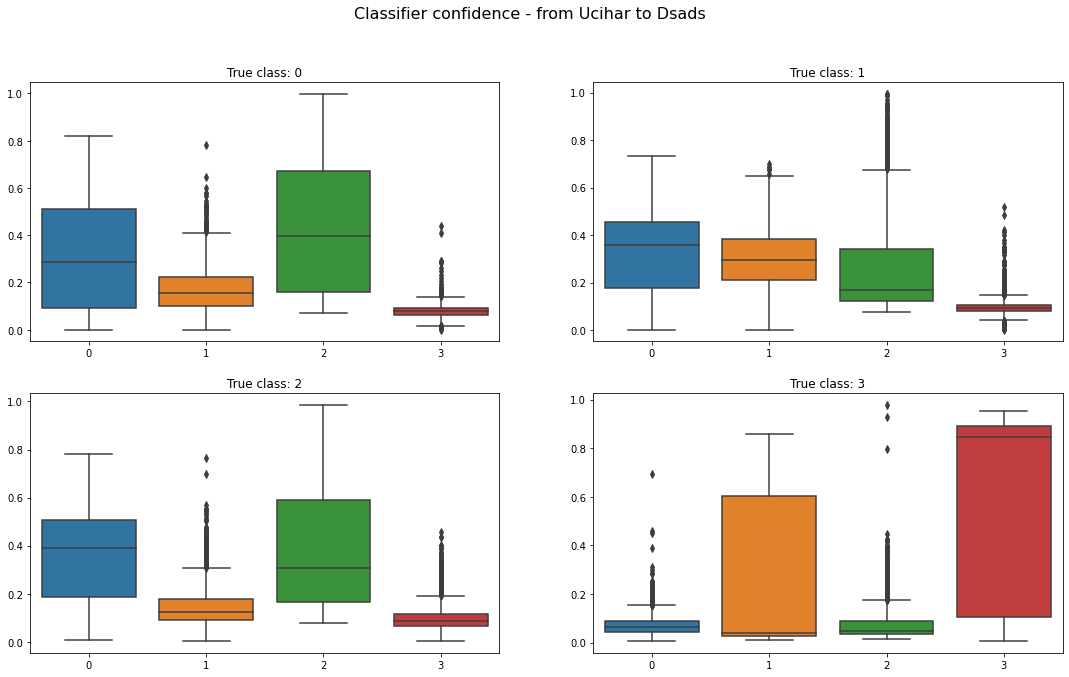

In [39]:
lim = 7.5
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
fig.suptitle(f'Classifier confidence - from {source} to {target}', fontsize=16)
for i in range(4):
    probs = probsTarget[np.where(trueTarget==i)[0]]
    sns.boxplot(data = pd.DataFrame(probs),ax = axs[int(i/2),i%2])
    axs[int(i/2),i%2].set_title(f'True class: {i}')
plt.savefig(f'../figures/clf_confidence_{source}to{target}.png')

A partir dos resultados analizado, apenas a classe 3 apresenta um desempenho satisfatório. 
Mas vale a pena o teste. A classe 3 é de fato mais discriminativa de todas. Quando ela é verdadadeira, a probabilidade média a mais alta.
Quando não é, os valores são os menores. 
Não dá pra prever o comportamento durante o treino, pois com a adição de labels a distribuição dessas probabilidades irá mudar. 

In [16]:

predSL =[]
trueSL = []
for t,p in zip(trueTarget,probsTarget):
    if max(p) > 0.8:
        predSL.append(np.argmax(p))
        trueSL.append(t)

In [17]:
accuracy_score(trueSL,predSL)

0.8392029657089898

In [18]:
len(trueSL)/len(trueTarget)

0.30106026785714285

In [19]:
accuracy_score(trueTarget,predTarget)

0.48130580357142855